In [43]:
# imports
import numpy as np
import pandas as pd
import requests
import logging

# finance
import yfinance as yf
import pandas_datareader as pdr
import talib as ta

# visualisation
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

# time
import time
from datetime import date, datetime, timedelta 

from scipy.stats import weibull_min


In [2]:
# downloading crypto from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # download sol
        coin = ["SOLUSDT"]

        def fetch_crypto_ohlc(coin, interval="1d"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 180 days back from today as it is max for binance api
            start_time = datetime.now() - timedelta(days=360)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=90)).timestamp() * 1000
                    ),  # fetching 90 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            ohlc_df["ticker"] = coin

            ohlc_df["timestamp"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df.set_index("timestamp", inplace=True)

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
            
            return ohlc_df[
                [
                    "ticker",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):

            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.dayofweek.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coin:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('sol.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()


2025-06-12 08:06:02,783 - INFO - Fetching data for SOLUSDT
2025-06-12 08:06:03,162 - INFO - Fetched data for SOLUSDT up to 2024-09-15 00:00:00.001000
2025-06-12 08:06:03,974 - INFO - Fetched data for SOLUSDT up to 2024-12-14 00:00:00.001000
2025-06-12 08:06:04,785 - INFO - Fetched data for SOLUSDT up to 2025-03-14 00:00:00.001000
2025-06-12 08:06:05,613 - INFO - Fetched data for SOLUSDT up to 2025-06-12 00:00:00.001000
2025-06-12 08:06:06,531 - WARNING - No OHLC data found for SOLUSDT.
2025-06-12 08:06:06,556 - INFO - Data fetching and processing complete. Data saved to crypto.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2024-06-18 to 2025-06-12
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          360 non-null    int64   
 1   month         360 non-null    int64   
 2   day           360 non-null    int64   
 3   hour          360 non-null    int64   
 4   ticker        360 non-null    category
 5   open          360 non-null    float64 
 6   high          360 non-null    float64 
 7   low           360 non-null    float64 
 8   close         360 non-null    float64 
 9   price_change  360 non-null    float64 
 10  volume        360 non-null    float64 
dtypes: category(1), float64(6), int64(4)
memory usage: 31.4 KB


In [44]:
# daily returns

# calculate daily returns based on close price
df = pd.read_csv("sol.csv", parse_dates=True, index_col=0)
df["return"] = df["close"].pct_change() * 100

mean_return = df["return"].mean()
median_return = df["return"].median()
volatility = df["return"].std()
skewness = df["return"].skew()
kurtosis = df["return"].kurt()

daily_sharpe = mean_return / volatility
annual_sharpe = daily_sharpe * np.sqrt(365)

print("Mean return:", mean_return)
print("Median return:", median_return)
print("Volatility:", volatility)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)
print("Daily Sharpe:", daily_sharpe)
print("Annual Sharpe:", annual_sharpe)

Mean return: 0.14448348607155748
Median return: 0.04214328717639937
Volatility: 4.578162354900778
Skewness: 0.4401357018762295
Kurtosis: 3.779466610417426
Daily Sharpe: 0.03155927528801867
Annual Sharpe: 0.6029391077856081


In [45]:
# Quantile
q1 = df["return"].quantile(0.25)
q3 = df["return"].quantile(0.75)
print("Q1:", q1)
print("Q3:", q3)

# value at risk
quantiles = df["return"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
var_95 = df["return"].quantile(0.05)  # Value at Risk (95%)
var_99 = df["return"].quantile(0.01)  # Value at Risk (99%)

print(f"VaR 95%: {var_95:.2f}%")
print(f"VaR 99%: {var_99:.2f}%")

Q1: -2.520420484567232
Q3: 2.631858356482719
VaR 95%: -6.70%
VaR 99%: -8.93%


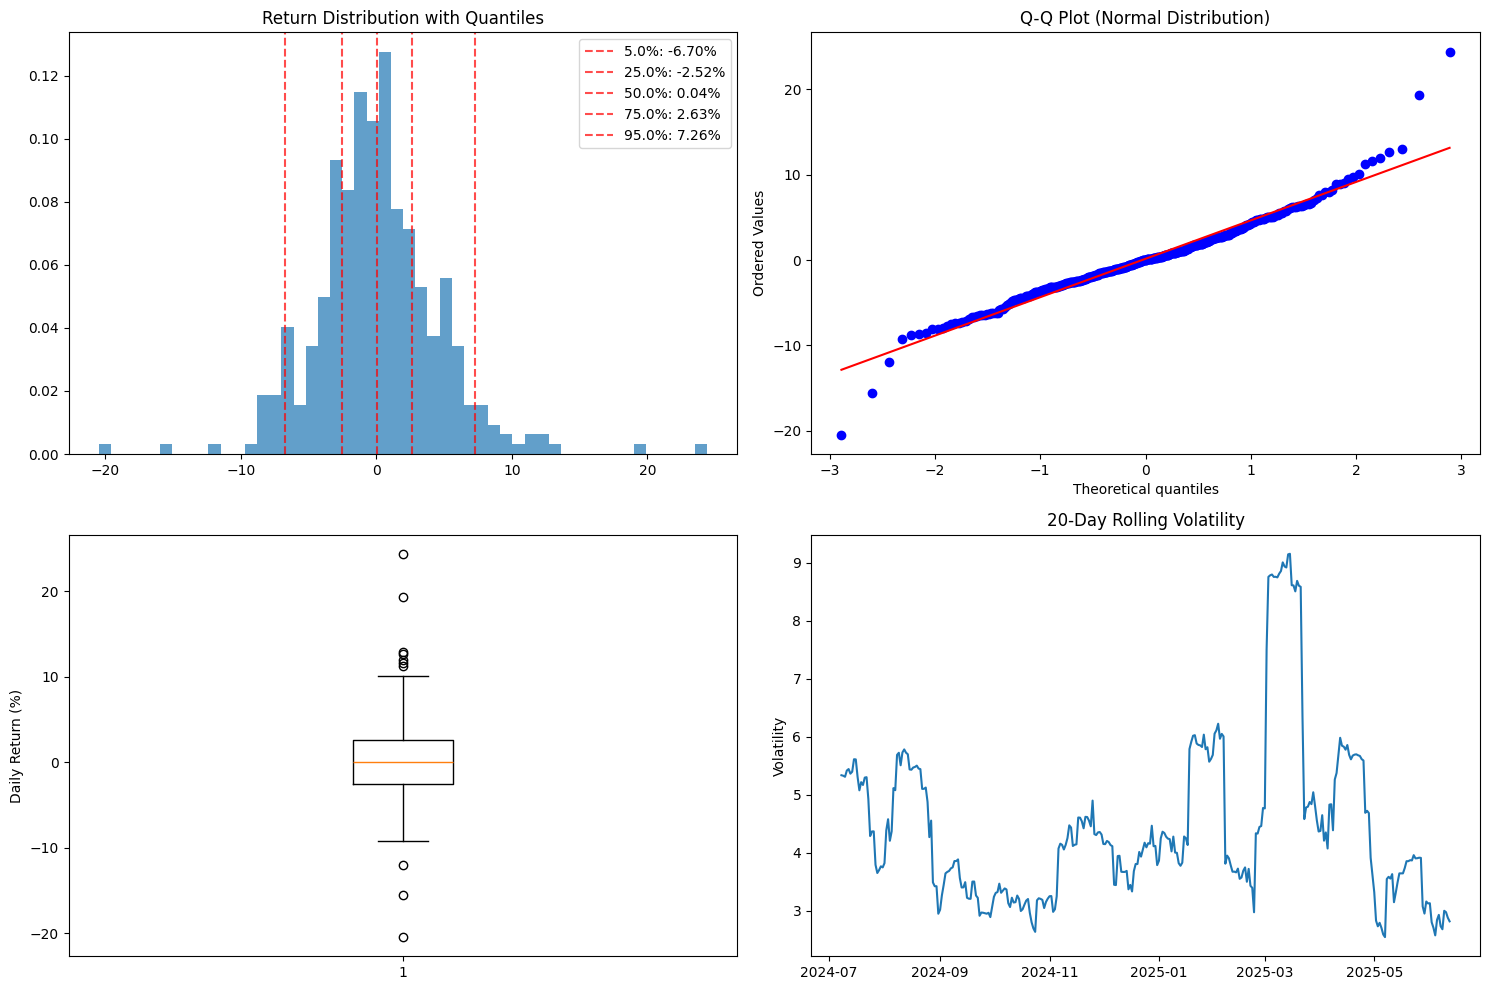

In [46]:
# visualization

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# histogram return
axes[0,0].hist(df["return"].dropna(), bins=50, alpha=0.7, density=True)
for q_val in [0.05, 0.25, 0.5, 0.75, 0.95]:
    axes[0,0].axvline(df["return"].quantile(q_val), 
                      color='red', linestyle='--', alpha=0.7,
                      label=f'{q_val*100}%: {df["return"].quantile(q_val):.2f}%')
axes[0,0].set_title("Return Distribution with Quantiles")
axes[0,0].legend()

# q-q plot normal distribution 
stats.probplot(df["return"].dropna(), dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q Plot (Normal Distribution)")

# box plot
axes[1,0].boxplot(df["return"].dropna())
axes[1,0].set_ylabel("Daily Return (%)")
axes[1,1].set_ylabel("Volatility (%)")

# rolling volatility
df["rolling_vol"] = df["return"].rolling(window=20).std()
axes[1,1].plot(df.index, df["rolling_vol"])
axes[1,1].set_title("20-Day Rolling Volatility")
axes[1,1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

In [57]:
# Key Insights:
# Distribution Analysis: 
# returns show approximately normal distribution in the center but with significant fat tails 
# extreme price movements occur much more frequently than normal distribution would predict
# makes traditional VaR models unreliable

# Q-Q Plot Critical Finding: 
# deviation from the red line at extremes confirms fat-tail behavior
# Standard risk models will consistently underestimate actual risk exposure

# Volatility Clustering: 
# high volatility periods cluster together
#quiet phases (3-4%) alternating with turbulent periods (up to 9%)
# volatility forecasting models could be highly valuable

#Strategic Implications:

#Dynamic position sizing based on current volatility regime
#Fat-tail risk models instead of normal distribution assumptions
#Volatility-based strategy switching (conservative in high-vol, aggressive in low-vol periods)
#Enhanced stop-loss management during volatility spikes

#Bottom Line: SOL behaves like a high-frequency extreme events asset requiring sophisticated risk management and volatility-adaptive strategies.

In [58]:
# creating new columns, with shift(1) to avoid data leakage

# volatility 
df['volatility_7d'] = df['close'].rolling(window=7).std().shift(1)
df['volume_change'] = df['volume'].pct_change().replace([np.inf, -np.inf], np.nan).shift(1)
# Volatility Regime Detection
df['vol_regime'] = np.where(df['volatility_7d'] > df['volatility_7d'].rolling(30).quantile(0.75), 2,  # High vol
                   np.where(df['volatility_7d'] < df['volatility_7d'].rolling(30).quantile(0.25), 0, 1))  # Low/Medium vol
# Volatility Momentum 
df['vol_momentum'] = df['volatility_7d'] / df['volatility_7d'].rolling(14).mean() - 1
# Extreme Move Detection 
df['extreme_down'] = (df['return'] < df['return'].rolling(252).quantile(0.05)).astype(int)
df['extreme_up'] = (df['return'] > df['return'].rolling(252).quantile(0.95)).astype(int)

# fat tails
# Consecutive Extreme Days
extreme_events = (df['extreme_down'] | df['extreme_up']).astype(int)
df['extreme_streak'] = extreme_events.groupby((extreme_events != extreme_events.shift()).cumsum()).cumsum()

# Volume Anomalies (oft vor extremen Bewegungen)
df['volume_zscore'] = (df['volume'] - df['volume'].rolling(30).mean()) / df['volume'].rolling(30).std()
df['volume_spike'] = (df['volume_zscore'] > 2).astype(int)

df['trend_alignment'] = ((df['close'] > df['close'].shift(1)) &
                         (df['close'] > df['close'].shift(7))).astype(int)

# breakout last 7 days
df['breakout_high_7d'] = (df['close'] > df['high'].rolling(window=7).max().shift(1)).astype(int)


# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # preventing leakage
    high_shift = df['high'].shift(1)
    low_shift = df['low'].shift(1)
    close_shift = df['close'].shift(1)
    open_shift = df['open'].shift(1)
    volume_shift = df['volume'].shift(1)
    
    # calculate various technical indicators using TA-Lib
    df['atr'] = ta.ATR(high_shift, low_shift, close_shift)
    df['atr_14'] = ta.ATR(high_shift, low_shift, close_shift, timeperiod=14)
    df['atr_ratio'] = df['atr'] / df['atr_14']
    df['adx'] = ta.ADX(high_shift, low_shift, close_shift)  
    df['roc'] = ta.ROC(close_shift) # momentum
    df['rsi'] = ta.RSI(close_shift) # momentum
    df['sma_30d'] = ta.SMA(close_shift, timeperiod=30)
    df['sma_50d'] = ta.SMA(close_shift, timeperiod=50)
    df['slowk'], _ = ta.STOCH(high_shift, low_shift, close_shift)
    upper, middle, lower = ta.BBANDS(close_shift, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['bb_upper'] = upper
    df['bb_middle'] = middle
    df['bb_lower'] = lower
    # Dynamische BB basierend auf aktueller Volatilität
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (close_shift - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    df['ema_9'] = ta.EMA(close_shift, timeperiod=9)
    df['ema_21'] = ta.EMA(close_shift, timeperiod=21)
    return df

df = add_ta_indicators(df)



# RSI Divergence für extreme Situationen
df['rsi_oversold_extreme'] = (df['rsi'] < 20).astype(int)  # Statt 30
df['rsi_overbought_extreme'] = (df['rsi'] > 80).astype(int)  # Statt 70

# Market Stress Indicator (kombiniert mehrere Signale)
df['market_stress'] = (df['vol_regime'] == 2).astype(int) + \
                      df['volume_spike'] + \
                      (df['atr_ratio'] > 1.5).astype(int)

# calculating golden cross and death cross for EMA 9 and EMA 21
df['ema9_above_ema21'] = np.where(df['ema_9'] > df['ema_21'], 1, 0)
df['golden_cross_ema'] = np.where((df['ema9_above_ema21'] != df['ema9_above_ema21'].shift(1)) & df['ema9_above_ema21'], 1, 0)
df['death_cross_ema'] = np.where((df['ema9_above_ema21'] != df['ema9_above_ema21'].shift(1)) & ~df['ema9_above_ema21'], 1, 0)

# delete now unnecessary column
df.drop(columns=['ema9_above_ema21', 'atr'], inplace=True)

In [59]:
df.tail(3)

,year,month,day,hour,ticker,open,high,low,close,price_change,...,bb_width,bb_position,ema_9,ema_21,rsi_oversold_extreme,rsi_overbought_extreme,market_stress,golden_cross_ema,death_cross_ema,slowk
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-06-10,2025,6,1,0,SOLUSDT,161.16,165.67,156.32,165.12,2.457185,...,0.271007,0.457485,155.211411,159.062134,0,0,0,0,0,67.393801
2025-06-11,2025,6,2,0,SOLUSDT,165.12,168.36,159.21,160.97,-2.513324,...,0.265554,0.557938,157.193129,159.612849,0,0,1,0,0,87.016852
2025-06-12,2025,6,3,0,SOLUSDT,160.98,161.28,158.74,159.12,-1.155423,...,0.248950,0.482299,157.948503,159.736226,0,0,1,0,0,86.762350


In [60]:
def exponential_volatility_analysis(df):
    """
    Exponential-Verteilung für Volatilitäts-Sprünge
    Wie oft kommen hohe Volatilitäts-Perioden vor?
    """
    print("\nEXPONENTIAL VOLATILITY ANALYSIS")
    print("-" * 40)
    
    # Calculate volatility
    df = df.copy()
    df['volatility'] = df['return'].rolling(7).std()
    
    # Remove NaN values
    vol_data = df['volatility'].dropna()
    
    if len(vol_data) > 20:
        # Fit exponential distribution
        loc, scale = stats.expon.fit(vol_data)
        lambda_param = 1 / scale
        
        print(f"Volatility observations: {len(vol_data)}")
        print(f"Mean volatility: {vol_data.mean():.2f}%")
        print(f"Exponential lambda: {lambda_param:.3f}")
        
        # Calculate probabilities for different volatility levels
        high_vol_threshold = vol_data.mean() + vol_data.std()
        extreme_vol_threshold = vol_data.mean() + 2 * vol_data.std()
        
        prob_high_vol = 1 - stats.expon.cdf(high_vol_threshold, loc, scale)
        prob_extreme_vol = 1 - stats.expon.cdf(extreme_vol_threshold, loc, scale)
        
        print(f"High volatility threshold: {high_vol_threshold:.2f}%")
        print(f"Probability of high volatility: {prob_high_vol:.1%}")
        print(f"Probability of extreme volatility: {prob_extreme_vol:.1%}")
        
        # Expected time between high volatility periods
        if prob_high_vol > 0:
            expected_days_between = 1 / prob_high_vol
            print(f"Expected days between high vol periods: {expected_days_between:.1f}")
        
        return {
            'exponential_params': (loc, scale),
            'lambda': lambda_param,
            'prob_high_vol': prob_high_vol,
            'prob_extreme_vol': prob_extreme_vol,
            'high_vol_threshold': high_vol_threshold
        }
    else:
        print("Not enough volatility data")
        return None

exp_result = exponential_volatility_analysis(df) 


EXPONENTIAL VOLATILITY ANALYSIS
----------------------------------------
Volatility observations: 353
Mean volatility: 4.21%
Exponential lambda: 0.304
High volatility threshold: 6.19%
Probability of high volatility: 20.2%
Probability of extreme volatility: 11.0%
Expected days between high vol periods: 5.0


In [61]:
def weibull_drawdown_analysis(df):
    """
    Weibull-Verteilung für Drawdown-Zeiten
    Wie lange dauert es bis Recovery?
    """
    print("WEIBULL DRAWDOWN ANALYSIS")
    print("-" * 40)
    
    # Calculate drawdowns
    df = df.copy()
    df['cumulative_return'] = (1 + df['return']/100).cumprod()
    df['running_max'] = df['cumulative_return'].expanding().max()
    df['drawdown'] = (df['cumulative_return'] / df['running_max'] - 1) * 100
    
    # Find drawdown periods and recovery times
    in_drawdown = df['drawdown'] < -1  # More than 1% drawdown
    drawdown_periods = []
    
    start = None
    for i, is_dd in enumerate(in_drawdown):
        if is_dd and start is None:
            start = i
        elif not is_dd and start is not None:
            drawdown_periods.append(i - start)
            start = None
    
    if len(drawdown_periods) > 5:
        # Fit Weibull to recovery times
        shape, loc, scale = stats.weibull_min.fit(drawdown_periods)
        
        print(f"Recovery times found: {len(drawdown_periods)}")
        print(f"Average recovery time: {np.mean(drawdown_periods):.1f} days")
        print(f"Weibull parameters - Shape: {shape:.2f}, Scale: {scale:.2f}")
        
        # Probabilities
        prob_quick_recovery = stats.weibull_min.cdf(7, shape, loc, scale)  # Within 7 days
        prob_long_recovery = 1 - stats.weibull_min.cdf(30, shape, loc, scale)  # More than 30 days
        
        print(f"Probability of recovery within 7 days: {prob_quick_recovery:.1%}")
        print(f"Probability of recovery taking >30 days: {prob_long_recovery:.1%}")
        
        return {
            'weibull_params': (shape, loc, scale),
            'recovery_times': drawdown_periods,
            'prob_quick_recovery_7d': prob_quick_recovery,
            'prob_long_recovery_30d': prob_long_recovery
        }
    else:
        print("Not enough drawdown periods found")
        return None
        
result = weibull_drawdown_analysis(df)


WEIBULL DRAWDOWN ANALYSIS
----------------------------------------
Recovery times found: 10
Average recovery time: 18.6 days
Weibull parameters - Shape: 0.43, Scale: 15.39
Probability of recovery within 7 days: 48.7%
Probability of recovery taking >30 days: 26.9%


In [62]:
def normal_returns_analysis(df):
    """
    Normal-Verteilung für tägliche Returns
    Klassische Risikoberechnung
    """
    print("\nNORMAL DISTRIBUTION RETURNS ANALYSIS")
    print("-" * 40)
    
    returns = df['return'].dropna()
    
    if len(returns) > 30:
        # Fit normal distribution
        mu, sigma = stats.norm.fit(returns)
        
        print(f"Return observations: {len(returns)}")
        print(f"Mean return: {mu:.2f}%")
        print(f"Standard deviation: {sigma:.2f}%")
        
        # Calculate risk metrics
        var_95 = stats.norm.ppf(0.05, mu, sigma)  # 5th percentile
        var_99 = stats.norm.ppf(0.01, mu, sigma)  # 1st percentile
        
        print(f"VaR 95%: {var_95:.2f}%")
        print(f"VaR 99%: {var_99:.2f}%")
        
        # Probabilities for specific return ranges
        prob_positive = 1 - stats.norm.cdf(0, mu, sigma)
        prob_big_gain = 1 - stats.norm.cdf(5, mu, sigma)  # >5% gain
        prob_big_loss = stats.norm.cdf(-5, mu, sigma)  # >5% loss
        
        print(f"Probability of positive return: {prob_positive:.1%}")
        print(f"Probability of >5% daily gain: {prob_big_gain:.1%}")
        print(f"Probability of >5% daily loss: {prob_big_loss:.1%}")
        
        # Sharpe ratio estimate
        sharpe_ratio = mu / sigma if sigma > 0 else 0
        print(f"Daily Sharpe ratio: {sharpe_ratio:.3f}")
        
        return {
            'normal_params': (mu, sigma),
            'var_95': var_95,
            'var_99': var_99,
            'prob_positive': prob_positive,
            'prob_big_gain': prob_big_gain,
            'prob_big_loss': prob_big_loss,
            'sharpe_ratio': sharpe_ratio
        }
    else:
        print("Not enough return data")
        return None

normal_result = normal_returns_analysis(df)


NORMAL DISTRIBUTION RETURNS ANALYSIS
----------------------------------------
Return observations: 359
Mean return: 0.14%
Standard deviation: 4.57%
VaR 95%: -7.38%
VaR 99%: -10.49%
Probability of positive return: 51.3%
Probability of >5% daily gain: 14.4%
Probability of >5% daily loss: 13.0%
Daily Sharpe ratio: 0.032


In [63]:
def poisson_events_analysis(df):
    """
    Poisson-Verteilung für diskrete Events
    Wie oft passieren große Bewegungen pro Woche?
    """
    print("\nPOISSON EVENTS ANALYSIS")
    print("-" * 40)
    
    # Define "big moves" as >3% daily change
    df = df.copy()
    df['big_move'] = (abs(df['return']) > 3).astype(int)
    
    # Count big moves per week
    df['week'] = df.index.to_period('W') if hasattr(df.index, 'to_period') else df.index // 7
    weekly_events = df.groupby('week')['big_move'].sum()
    
    if len(weekly_events) > 10:
        # Fit Poisson distribution
        lambda_param = weekly_events.mean()
        
        print(f"Weeks analyzed: {len(weekly_events)}")
        print(f"Total big moves (>3%): {weekly_events.sum()}")
        print(f"Average big moves per week: {lambda_param:.2f}")
        
        # Calculate probabilities
        prob_zero_events = stats.poisson.pmf(0, lambda_param)
        prob_one_event = stats.poisson.pmf(1, lambda_param)
        prob_multiple_events = 1 - stats.poisson.cdf(1, lambda_param)
        prob_many_events = 1 - stats.poisson.cdf(3, lambda_param)  # More than 3
        
        print(f"Probability of 0 big moves in a week: {prob_zero_events:.1%}")
        print(f"Probability of exactly 1 big move: {prob_one_event:.1%}")
        print(f"Probability of 2+ big moves in a week: {prob_multiple_events:.1%}")
        print(f"Probability of 4+ big moves in a week: {prob_many_events:.1%}")
        
        return {
            'poisson_lambda': lambda_param,
            'weekly_events': weekly_events.tolist(),
            'prob_zero_events': prob_zero_events,
            'prob_multiple_events': prob_multiple_events,
            'prob_many_events': prob_many_events
        }
    else:
        print("Not enough weekly data")
        return None

poisson_result = poisson_events_analysis(df)


POISSON EVENTS ANALYSIS
----------------------------------------
Weeks analyzed: 52
Total big moves (>3%): 150
Average big moves per week: 2.88
Probability of 0 big moves in a week: 5.6%
Probability of exactly 1 big move: 16.1%
Probability of 2+ big moves in a week: 78.3%
Probability of 4+ big moves in a week: 32.7%


In [64]:
def gamma_volume_analysis(df):
    """
    Gamma-Verteilung für Handelsvolumen
    Modelliert right-skewed Volume-Verteilung
    """
    print("\nGAMMA VOLUME ANALYSIS")
    print("-" * 40)
    
    # Use volume data
    volume_data = df['volume'].dropna()
    
    if len(volume_data) > 30:
        # Fit Gamma distribution
        try:
            alpha, loc, beta = stats.gamma.fit(volume_data)
            
            print(f"Volume observations: {len(volume_data)}")
            print(f"Mean volume: {volume_data.mean():.0f}")
            print(f"Gamma parameters - Alpha: {alpha:.2f}, Beta: {beta:.0f}")
            
            # Calculate volume percentiles
            vol_50 = stats.gamma.ppf(0.5, alpha, loc, beta)
            vol_90 = stats.gamma.ppf(0.9, alpha, loc, beta)
            vol_95 = stats.gamma.ppf(0.95, alpha, loc, beta)
            
            print(f"Median volume (50th percentile): {vol_50:.0f}")
            print(f"High volume (90th percentile): {vol_90:.0f}")
            print(f"Very high volume (95th percentile): {vol_95:.0f}")
            
            # Probability of unusual volume
            current_avg_volume = volume_data.mean()
            prob_above_avg = 1 - stats.gamma.cdf(current_avg_volume, alpha, loc, beta)
            prob_very_high = 1 - stats.gamma.cdf(vol_90, alpha, loc, beta)
            
            print(f"Probability of above-average volume: {prob_above_avg:.1%}")
            print(f"Probability of very high volume: {prob_very_high:.1%}")
            
            return {
                'gamma_params': (alpha, loc, beta),
                'volume_percentiles': {'50%': vol_50, '90%': vol_90, '95%': vol_95},
                'prob_above_avg': prob_above_avg,
                'prob_very_high': prob_very_high
            }
        except:
            print("Could not fit Gamma distribution to volume")
            return None
    else:
        print("Not enough volume data")
        return None

gamma_result = gamma_volume_analysis(df)


GAMMA VOLUME ANALYSIS
----------------------------------------
Volume observations: 360
Mean volume: 4099713
Gamma parameters - Alpha: 0.00, Beta: 29
Median volume (50th percentile): 24267558
High volume (90th percentile): 24267558
Very high volume (95th percentile): 24267558
Probability of above-average volume: 100.0%
Probability of very high volume: 100.0%
